### First, this notebook creates a static version of the MODIS product to classify MTBS fires outside of the 2003-2016 MODIS data range. Then, it classifies all fires in MTBS. Finally, this notebook runs a time-varying fit on MTBS data in the USA and creates toy visualizations to show how the CCDF shape changes over time.

In [1]:
import os
import re
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats
import pickle
import sys

sys.path.append("..")
from utils.temporal_analysis import *
from utils import wildfire_powerlaw as wfpl

First, build the static raster tiles (so that it can be applied to fires outside 2003-2016)

In [2]:
#REPLACE WITH FILEPATH TO ORIGINAL MTBS DATA
mtbs_gdf = load_shapefile(
    "/Users/lukevonkapff/wildfires/MTBS/S_USA.MTBS_BURN_AREA_BOUNDARY.shp",
    "EPSG:4269",
    area_col="AREA_SQKM"
)

mtbs_filtered = mtbs_gdf[mtbs_gdf["AREA_SQKM"] >= 4].copy()
mtbs_filtered = mtbs_filtered.rename(columns={"YEAR": "year", "AREA_SQKM": "area_km2"})

In [3]:
# REPLACE WITH PATH TO MODIS/GEOTIFF FOLDER (CREATED IN 3_LAND_COVER_CLASSIFICATION NOTEBOOK)
modis_folder = "/Users/lukevonkapff/wildfires/MODIS_USA/GeoTIFF"
modis_files = [os.path.join(modis_folder, f) for f in os.listdir(modis_folder) if f.endswith(".tif")]
modis_by_year = {}
for f in modis_files:
    match = re.search(r"A(\d{4})", os.path.basename(f))
    if match:
        year = int(match.group(1))
        modis_by_year.setdefault(year, []).append(f)

modis_to_gfa = {
    0: "Water",
    1: "Evergreen Needleleaf forest",
    2: "Evergreen Broadleaf forest",
    3: "Deciduous Needleleaf forest",
    4: "Deciduous Broadleaf forest",
    5: "Mixed forest",
    6: "Closed shrublands",
    7: "Open shrublands",
    8: "Woody savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent wetlands",
    12: "Croplands",
    13: "Urban and built-up",
    14: "Cropland/Natural vegetation mosaic",
    15: "Snow and ice",
    16: "Barren or sparsely vegetated"
}

static_raster = build_static_modis_tiles(modis_by_year)

Use the static raster to classify all MTBS fires.

In [4]:
mtbs_classified = classify_with_modis(mtbs_filtered, "year", modis_by_year, modis_to_gfa)

output_path = "../data/mtbs_classified_static.shp"
mtbs_classified.to_file(output_path)
print(f"Saved GeoDataFrame to {output_path}")

Saved GeoDataFrame to ../data/mtbs_classified_static.shp


Evaluate how well new static raster mapping matches original time-varying raster.

In [5]:
overlap_mask = (mtbs_classified["year"].between(2003, 2016)) & \
               (mtbs_classified["modis_clas"] != "Unknown")

comparison_df = mtbs_classified.loc[overlap_mask].copy()
comparison_df["match"] = (
    comparison_df["modis_clas"] == comparison_df["modis_cl_1"]
)

agreement_rate = comparison_df["match"].mean()
print(f"Agreement between time-varying and static MODIS classifications (2003–2016): {agreement_rate:.2%}")
print(comparison_df[["year", "area_km2", "modis_clas", "modis_cl_1", "match"]].head())

KeyError: 'modis_clas'

## 2 visualizations to justify keeping xmin = 4 cutoff...

In [1]:
plot_fire_counts_faceted(mtbs_classified)

NameError: name 'plot_fire_counts_faceted' is not defined

In [2]:
fire_threshold_analysis(mtbs_classified,
                                year_col="year",
                                area_col="area_km2",
                                thresholds=[4, 8, 12, 16, 20])

NameError: name 'fire_threshold_analysis' is not defined

Thus, there is no other min fire size threshold that will eliminate large jumps in fire size after a certain year, meaning we can stick with 4km2. Now, let's run the fitting routine on each biome using the new land cover classification.

In [ ]:
# This cell takes a long time to run -- the overall_results output is in data folder

overall_results = {}

for modis_cat, subset in mtbs_classified.groupby("modis_cl_1"):
    data = subset["area_km2"].values
    
    if len(data) == 0:
        continue
    
    print(f"\n=== {modis_cat} (n={len(data)}) ===")
    
    params = wfpl.summarize_parameters_bootstrap(
        data, R=50, xmin=4, random_state=42
    )
    R, best = wfpl.likelihood_matrix_and_best(
        data, xmin=4
    )
    
    overall_results[modis_cat] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best
    }

save_path = "../data/mtbs_static_fits_by_biome.pkl"
with open(save_path, "wb") as f:
    pickle.dump(overall_results, f)

print(f"Saved overall_results to: {save_path}")

And now, we run the time-varying version of the fitting routine where each parameter is written as p1+p2*t (with modification for truncated power law, see utils). 

In [4]:
timevary_results = analyze_time_varying_mle(mtbs_classified, overall_results, xmin = 4, R_boot = 150)
df_both = summarize_timevary_results_mode(timevary_results, mode="both")


save_path_time_varying = "../data/mtbs_time_varying_fits_by_biome.pkl"
with open(save_path_time_varying, "wb") as f:
    pickle.dump(timevary_results, f)

print(f"Saved overall_results to: {save_path_time_varying}")


=== Barren or sparsely vegetated skipped: only 10 fires above xmin (4) ===

=== Closed shrublands skipped: only 159 fires above xmin (4) ===

=== Cropland/Natural vegetation mosaic skipped: only 2 fires above xmin (4) ===

=== Croplands skipped: only 208 fires above xmin (4) ===

=== Deciduous Broadleaf forest (n=2041 fires ≥ 4) ===

=== Evergreen Broadleaf forest (n=1388 fires ≥ 4) ===

=== Evergreen Needleleaf forest (n=1111 fires ≥ 4) ===

=== Grasslands (n=10438 fires ≥ 4) ===

=== Mixed forest (n=1268 fires ≥ 4) ===

=== Open shrublands (n=1433 fires ≥ 4) ===

=== Permanent wetlands skipped: only 238 fires above xmin (4) ===

=== Savannas (n=3044 fires ≥ 4) ===

=== Unknown skipped: only 34 fires above xmin (4) ===

=== Urban and built-up skipped: only 16 fires above xmin (4) ===

=== Water skipped: only 1 fires above xmin (4) ===

=== Woody savannas (n=3865 fires ≥ 4) ===


In [5]:
df_both

=== BOTH PARAMETERS ===


,biome,distribution,n,p1,p1_se,p1',p1'_se,p2,p2_se,p2',p2'_se,p1_slope_sig,p2_slope_sig
0,Deciduous Broadleaf forest,generalized_pareto,2041,0.470531,5.575397e-02,-0.086010,0.051314,4.669513,2.537862e-01,-0.809641,0.219984,0,1
1,Evergreen Broadleaf forest,generalized_pareto,1388,0.408186,7.139717e-02,-0.164975,0.071638,5.071971,3.456671e-01,0.318179,0.302524,1,0
2,Evergreen Needleleaf forest,lognormal,1111,2.804982,7.421946e-02,0.099899,0.072907,1.186876,5.878887e-02,0.100074,0.051596,0,0
3,Evergreen Needleleaf forest,stretched_exponential,1111,26.265964,1.049243e+01,-0.168502,0.576014,0.207096,1.016648e-02,-0.012629,0.003391,0,1
4,Evergreen Needleleaf forest,truncated_power_law,1111,1.560384,1.590889e-16,-0.176678,0.295062,0.000787,3.252607e-19,0.000655,0.000400,0,0
5,Evergreen Needleleaf forest,weibull,1111,0.694145,3.123652e-02,-0.059778,0.027547,32.044002,2.870643e+00,4.044549,1.624019,1,1
6,Grasslands,lognormal,10438,2.719330,5.178876e-02,0.048189,0.049708,1.096842,3.663244e-02,0.052059,0.034201,0,0
7,Grasslands,stretched_exponential,10438,12.333152,1.102790e+01,-0.358208,0.514439,0.229822,1.068565e-02,-0.004910,0.002137,0,1
8,Grasslands,weibull,10438,0.729872,2.188271e-02,-0.037011,0.019076,27.753393,1.682005e+00,2.092591,1.252268,0,0
9,Mixed forest,generalized_pareto,1268,0.426512,9.392840e-02,-0.224249,0.084325,2.924505,3.501144e-01,0.674780,0.302795,1,1


Toy visualizations to show quickly how tail shape is changing for significant parameter changes.

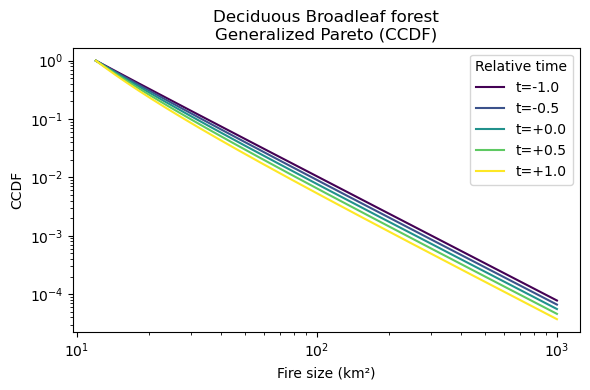

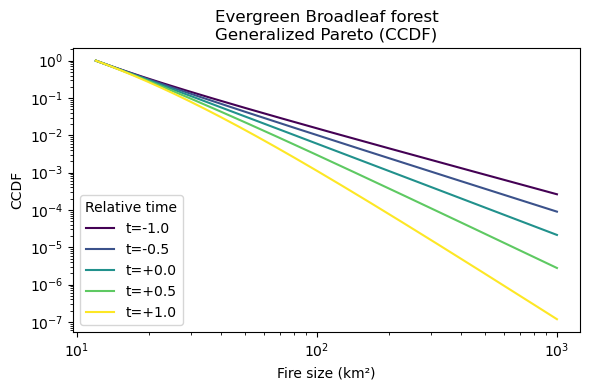

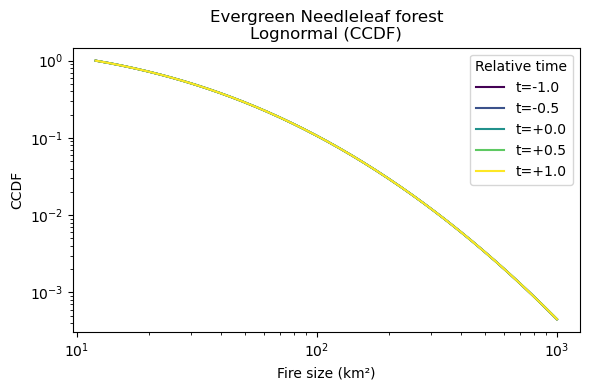

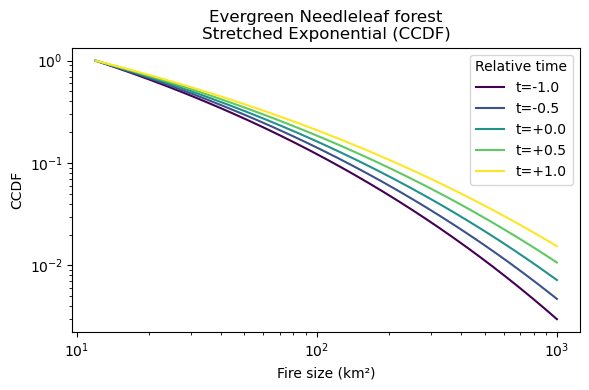

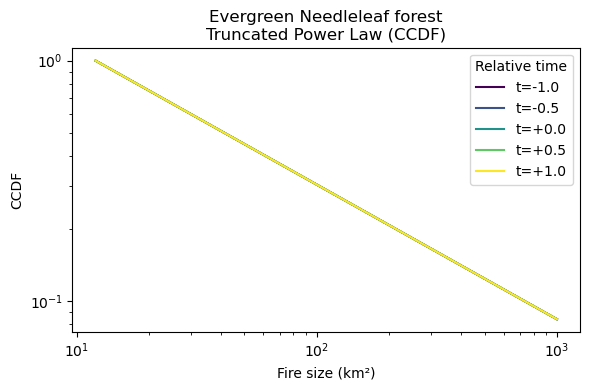

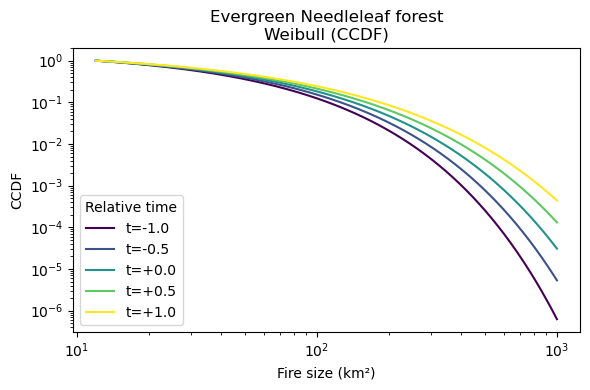

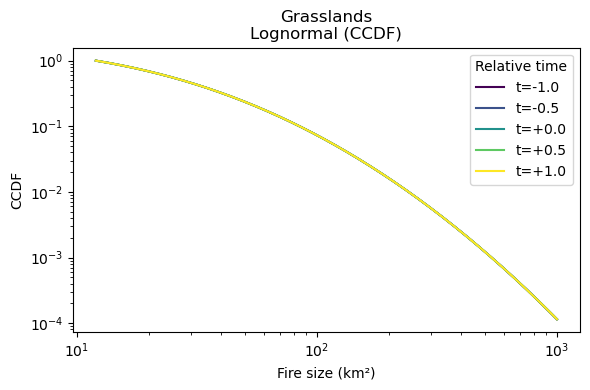

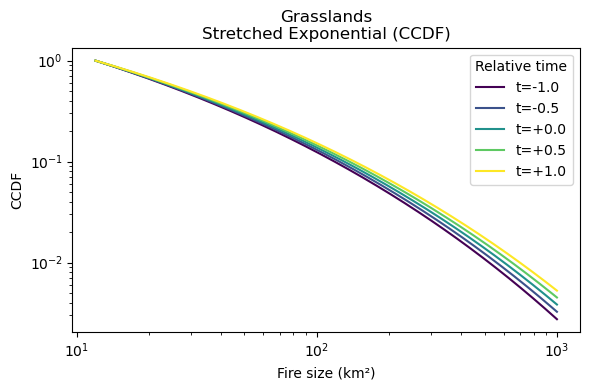

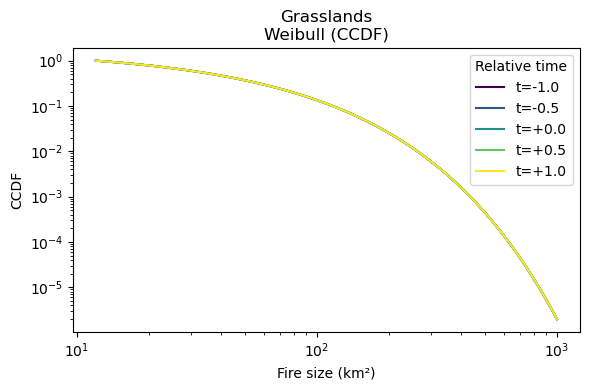

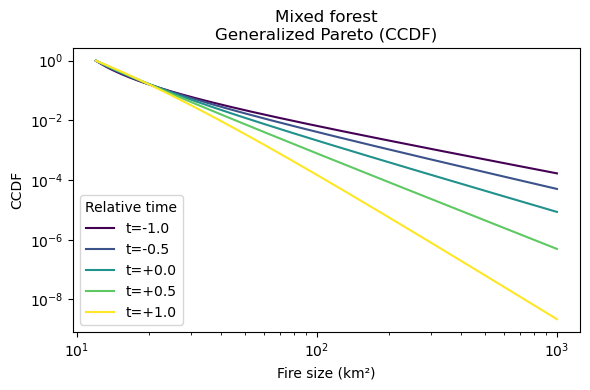

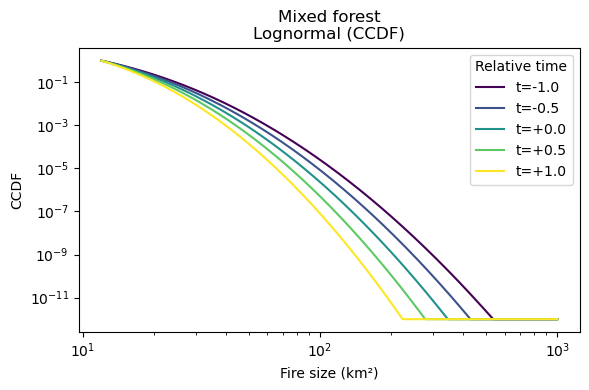

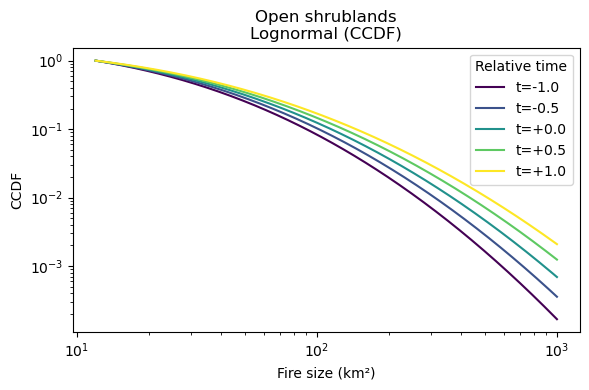

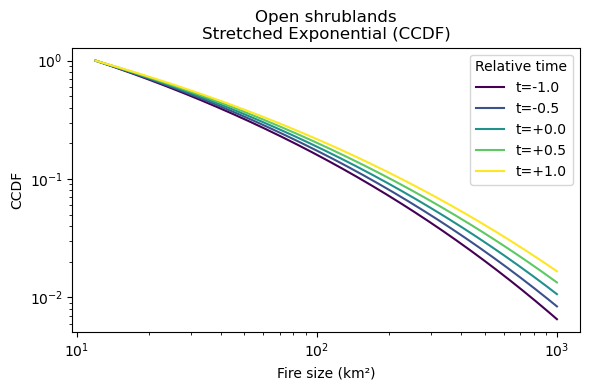

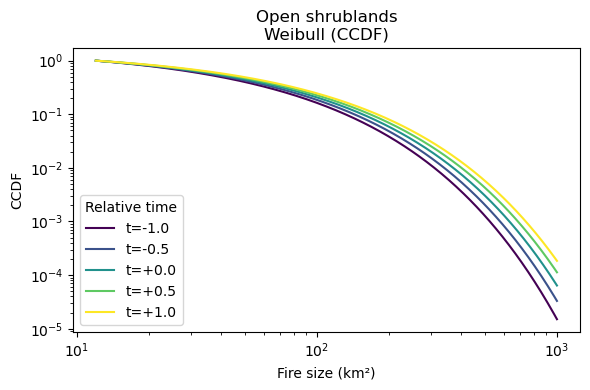

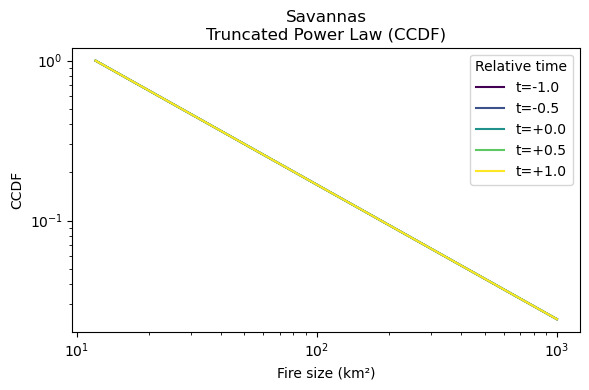

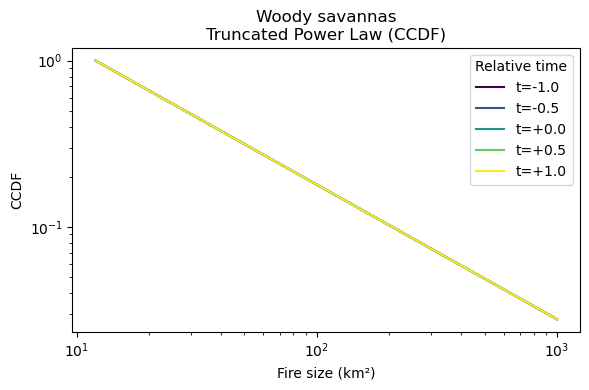

In [6]:
plot_distribution_evolution_ccdf(df_both)

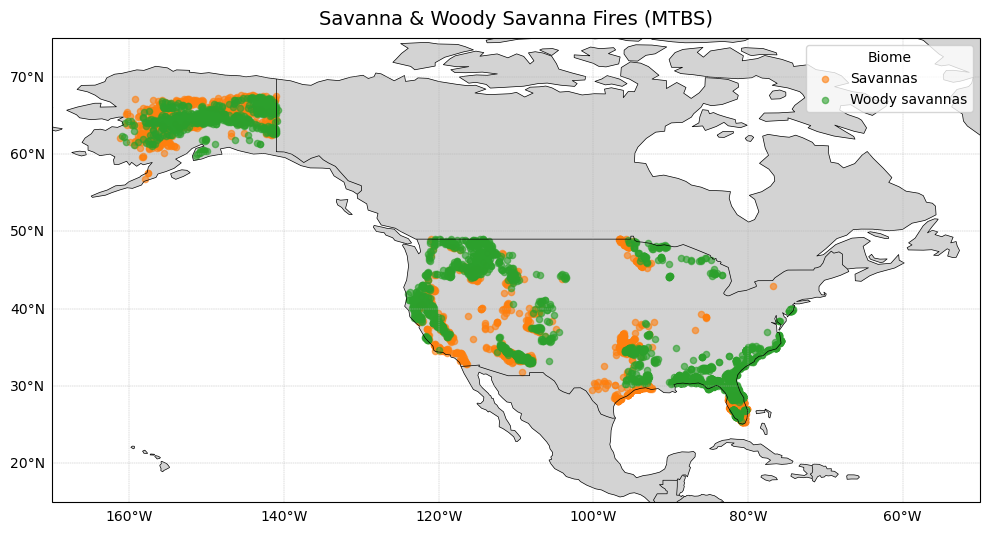

In [7]:
# In case one is curious distribution of savanna fires
# Can easily to tweaked to show where other biome fires exist
plot_savanna_fires(mtbs_classified, biome = "both")